In [1]:
import pandas as pd, datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
df = pd.read_csv('data/Pizza_Sale.csv')
df1 = pd.read_csv('data/Pizza_ingredients.csv')

In [104]:
# Step 1: Create a dictionary mapping from (pizza_ingredients, pizza_size) to pizza_name_id
temp_df_for_null = df.dropna(subset=['pizza_name_id']).groupby(
    ['pizza_ingredients', 'pizza_size']
)['pizza_name_id'].first().to_dict()

# Step 2: Use the dictionary to fill missing values
df['pizza_name_id'] = df.apply(
    lambda row: temp_df_for_null.get((row['pizza_ingredients'], row['pizza_size']))
    if pd.isna(row['pizza_name_id']) else row['pizza_name_id'],
    axis=1
)


In [105]:
# Step 1: Create a dictionary mapping from (pizza_ingredients, pizza_size) to pizza_name_id
temp_df_for_null = df.dropna(subset=['pizza_ingredients']).groupby(
    ['pizza_name_id']
)['pizza_ingredients'].first().to_dict()

# Step 2: Use the dictionary to fill missing values
df['pizza_ingredients'] = df.apply(
    lambda row: temp_df_for_null.get((row['pizza_name_id']))
    if pd.isna(row['pizza_ingredients']) else row['pizza_ingredients'],
    axis=1
)

In [106]:
# Step 1: Create a dictionary mapping from (pizza_ingredients, pizza_size) to pizza_name_id
temp_df_for_null = df.dropna(subset=['pizza_category']).groupby(
    ['pizza_name']
)['pizza_category'].first().to_dict()

# Step 2: Use the dictionary to fill missing values
df['pizza_category'] = df.apply(
    lambda row: temp_df_for_null.get((row['pizza_name']))
    if pd.isna(row['pizza_category']) else row['pizza_category'],
    axis=1
)

In [107]:
# Step 1: Create a dictionary mapping from (pizza_ingredients, pizza_size) to pizza_name_id
temp_df_for_null = df.dropna(subset=['pizza_name']).groupby(
    ['pizza_name_id']
)['pizza_name'].first().to_dict()

# # Step 2: Use the dictionary to fill missing values
df['pizza_name'] = df.apply(
    lambda row: temp_df_for_null.get((row['pizza_name_id']))
    if pd.isna(row['pizza_name']) else row['pizza_name'],
    axis=1
)

In [108]:
# Step 1: Create a dictionary mapping from (pizza_ingredients, pizza_size) to pizza_name_id
temp_df_for_null = df.dropna(subset=['total_price','unit_price','quantity']).groupby(
    ['pizza_name_id']
)['unit_price'].first().to_dict()

# # Step 2: Use the dictionary to fill missing values
df['total_price'] = df.apply(
    lambda row: temp_df_for_null.get((row['pizza_name_id']),row['unit_price']*int(row['quantity']))
    if pd.isna(row['total_price']) else row['total_price'],
    axis=1
    
)

In [109]:
# need to standardize the date format
df['order_date'] = df['order_date'].str.replace('-', '/')

In [110]:
df['order_date'] = pd.to_datetime(df['order_date'],format="%d/%m/%Y", errors='raise')

In [111]:
# Extract features
df['year'] = df['order_date'].dt.year
df['month'] = df['order_date'].dt.month
df['day'] = df['order_date'].dt.day
df['day_of_week'] = df['order_date'].dt.dayofweek
df['week_number'] = df['order_date'].dt.isocalendar().week
df['is_weekend'] = df['order_date'].dt.dayofweek >= 5

In [112]:
def get_season(date):
    if date.month in [12, 1, 2]:
        return 'Winter'
    elif date.month in [3, 4, 5]:
        return 'Spring'
    elif date.month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

df['season'] = df['order_date'].apply(get_season)


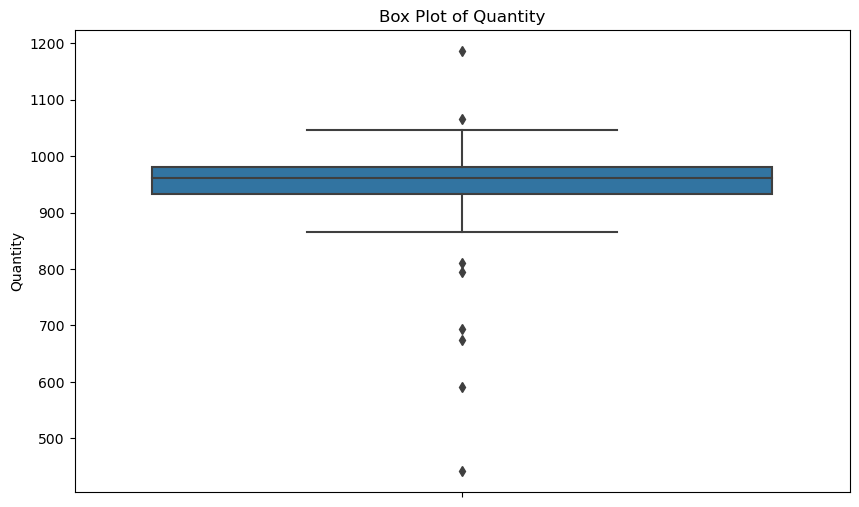

In [113]:
weekly_sales = df.groupby('week_number')['quantity'].sum().reset_index()

# Plot the box plot for the quantity column
plt.figure(figsize=(10, 6))
sns.boxplot(y=weekly_sales['quantity'])
plt.title('Box Plot of Quantity')
plt.ylabel('Quantity')
plt.show()

In [14]:
# Group by week_number, pizza_name_id, and unit_price
grouped = df.groupby(['week_number', 'pizza_name_id', 'unit_price'])['quantity'].sum().reset_index()

# Calculate the weekly average quantity
weekly_avg = grouped.groupby(['pizza_name_id', 'unit_price'])['quantity'].median().reset_index()
weekly_avg = weekly_avg.rename(columns={'quantity': 'weekly_avg_quantity'})

# Sort the DataFrame by weekly_avg_quantity in descending order
sorted_df = weekly_avg.sort_values(by='weekly_avg_quantity', ascending=False).reset_index(drop=True)

sorted_df

,pizza_name_id,unit_price,weekly_avg_quantity
0,big_meat_s,12.00,36.0
1,thai_ckn_l,20.75,27.0
2,five_cheese_l,18.50,26.0
3,four_cheese_l,17.95,25.0
4,classic_dlx_m,16.00,22.0
...,...,...,...
86,mexicana_s,12.00,3.0
87,ckn_alfredo_s,12.75,2.0
88,calabrese_s,12.25,2.0
89,green_garden_l,20.25,2.0


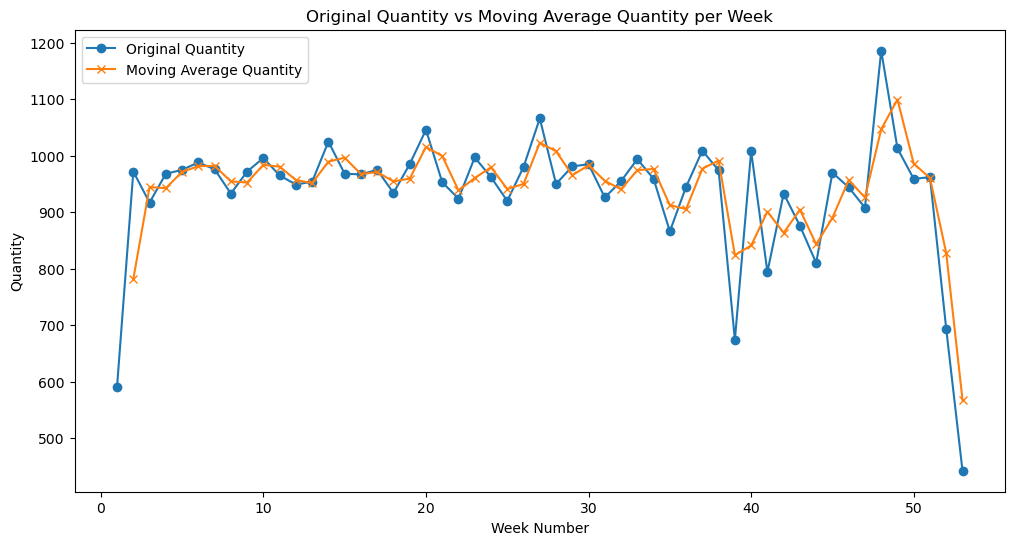

In [15]:
# Aggregate data by week_number
weekly_data = df.groupby('week_number')['quantity'].sum().reset_index()

# Calculate the moving average with a window of 3 weeks
weekly_data['moving_avg_quantity'] = weekly_data['quantity'].rolling(window=2).mean()

# Plot the original quantity and moving average
plt.figure(figsize=(12, 6))
plt.plot(weekly_data['week_number'], weekly_data['quantity'], label='Original Quantity', marker='o')
plt.plot(weekly_data['week_number'], weekly_data['moving_avg_quantity'], label='Moving Average Quantity', marker='x')
plt.title('Original Quantity vs Moving Average Quantity per Week')
plt.xlabel('Week Number')
plt.ylabel('Quantity')
plt.legend()
plt.show()


In [16]:
pizza_sales = df.groupby(['order_date', 'pizza_name_id'])['quantity'].sum().reset_index()

In [17]:
pizza_sales['order_date'] = pd.to_datetime(pizza_sales['order_date'])
full_dates = pd.date_range(start=pizza_sales['order_date'].min(),
                           end=pizza_sales['order_date'].max())

all_pizzas = pizza_sales['pizza_name_id'].unique()
complete_data = []

for pizza in all_pizzas:
    temp = pizza_sales[pizza_sales['pizza_name_id'] == pizza]
    temp = temp.set_index('order_date').reindex(full_dates, fill_value=0).reset_index()
    temp['pizza_name_id'] = pizza
    complete_data.append(temp)

pizza_sales = pd.concat(complete_data)
pizza_sales.rename(columns={'index': 'order_date'}, inplace=True)

In [18]:
pizza_sales 

,order_date,pizza_name_id,quantity
0,2015-01-01,bbq_ckn_l,6
1,2015-01-02,bbq_ckn_l,3
2,2015-01-03,bbq_ckn_l,3
3,2015-01-04,bbq_ckn_l,6
4,2015-01-05,bbq_ckn_l,1
...,...,...,...
360,2015-12-27,the_greek_xxl,0
361,2015-12-28,the_greek_xxl,0
362,2015-12-29,the_greek_xxl,0
363,2015-12-30,the_greek_xxl,0


In [19]:
# Aggregate the data by 'order_date' and 'pizza_name_id'
aggregated_df = df.groupby(['order_date', 'pizza_name_id']).agg({
    'quantity': 'sum'
}).reset_index()

# Create separate DataFrames for each pizza ID and resample weekly
pizza_ids = df['pizza_name_id'].unique()
pizza_dfs = {}

for pizza_id in pizza_ids:
    temp_df = aggregated_df[aggregated_df['pizza_name_id'] == pizza_id]
    temp_df.set_index('order_date', inplace=True)
    # Drop the 'pizza_name_id' column
    temp_df = temp_df.drop('pizza_name_id', axis=1)

    pizza_dfs[pizza_id] = temp_df['quantity'].resample('W').sum()
    print(f"DataFrame for {pizza_id}:\n{pizza_dfs[pizza_id]}\n")


DataFrame for hawaiian_m:
order_date
2015-01-04     5
2015-01-11     5
2015-01-18     3
2015-01-25     4
2015-02-01    11
2015-02-08    11
2015-02-15     8
2015-02-22    12
2015-03-01     8
2015-03-08    18
2015-03-15     9
2015-03-22    10
2015-03-29    10
2015-04-05    13
2015-04-12     9
2015-04-19     6
2015-04-26    11
2015-05-03    10
2015-05-10    11
2015-05-17     5
2015-05-24     6
2015-05-31     9
2015-06-07     8
2015-06-14    13
2015-06-21    10
2015-06-28    15
2015-07-05    10
2015-07-12    13
2015-07-19     4
2015-07-26    14
2015-08-02     9
2015-08-09    12
2015-08-16    13
2015-08-23    13
2015-08-30     5
2015-09-06     8
2015-09-13    11
2015-09-20     8
2015-09-27     6
2015-10-04     8
2015-10-11     9
2015-10-18     8
2015-10-25     8
2015-11-01     3
2015-11-08     3
2015-11-15    13
2015-11-22     9
2015-11-29    11
2015-12-06    14
2015-12-13    13
2015-12-20     7
2015-12-27     8
2016-01-03     3
Freq: W-SUN, Name: quantity, dtype: int64

DataFrame for class

In [20]:
import pandas as pd

# Function to cap outliers
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower_bound, upper_bound)

# Apply the capping function to all DataFrames in pizza_dfs
for pizza_id in pizza_dfs:
    pizza_dfs[pizza_id] = cap_outliers(pizza_dfs[pizza_id])
    print(f"Capped DataFrame for {pizza_id}:\n{pizza_dfs[pizza_id]}\n")


Capped DataFrame for hawaiian_m:
order_date
2015-01-04     5
2015-01-11     5
2015-01-18     3
2015-01-25     4
2015-02-01    11
2015-02-08    11
2015-02-15     8
2015-02-22    12
2015-03-01     8
2015-03-08    17
2015-03-15     9
2015-03-22    10
2015-03-29    10
2015-04-05    13
2015-04-12     9
2015-04-19     6
2015-04-26    11
2015-05-03    10
2015-05-10    11
2015-05-17     5
2015-05-24     6
2015-05-31     9
2015-06-07     8
2015-06-14    13
2015-06-21    10
2015-06-28    15
2015-07-05    10
2015-07-12    13
2015-07-19     4
2015-07-26    14
2015-08-02     9
2015-08-09    12
2015-08-16    13
2015-08-23    13
2015-08-30     5
2015-09-06     8
2015-09-13    11
2015-09-20     8
2015-09-27     6
2015-10-04     8
2015-10-11     9
2015-10-18     8
2015-10-25     8
2015-11-01     3
2015-11-08     3
2015-11-15    13
2015-11-22     9
2015-11-29    11
2015-12-06    14
2015-12-13    13
2015-12-20     7
2015-12-27     8
2016-01-03     3
Freq: W-SUN, Name: quantity, dtype: int64

Capped DataF

----------------------------

In [21]:
import itertools
p = range(0,8)
d = range(0,8)
q = range(0,2)

pdq_comb = list(itertools.product(p, d, q))

In [24]:
import warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings("ignore")

best_result = []


for pdq in pdq_comb:
    try:
        # Fit the ARIMA model
        model = ARIMA(pizza_dfs['hawaiian_m'], order=pdq).fit()
        
        # Make predictions
        predicted_values = model.forecast(steps=len(pizza_dfs['hawaiian_m']))
        
        # Calculate MAPE
        mape = mean_absolute_percentage_error(pizza_dfs['hawaiian_m'], predicted_values)
        
        # Store the MAPE and corresponding pdq
        best_result.append({
            'pdq': pdq,
            'MAPE': mape,
            'pizza': 'hawaiian_m'
        })
        
    except:
        continue


# Find the best pdq combination with the lowest MAPE for each pizza_id

results_for_pizza = [result for result in best_result if result['pizza'] == 'hawaiian_m']
if results_for_pizza:
    best_pdq = min(results_for_pizza, key=lambda x: x['MAPE'])
    print(f"Best pdq for pizza hawaiian_m: {best_pdq['pdq']}")
    print(f"Best MAPE for pizza hawaiian_m: {best_pdq['MAPE']}")



Best pdq for pizza hawaiian_m: (7, 1, 0)
Best MAPE for pizza hawaiian_m: 0.39279488541305047


In [ ]:
# import warnings
# import pandas as pd
# import statsmodels.api as sm
# from statsmodels.tsa.arima.model import ARIMA
# from sklearn.metrics import mean_absolute_percentage_error

# # Suppress warnings
# warnings.filterwarnings("ignore")

# best_result = []

# for pizza_id in pizza_ids:
#     for pdq in pdq_comb:
#         try:
#             # Fit the ARIMA model
#             model = ARIMA(pizza_dfs[pizza_id], order=pdq).fit()
            
#             # Make predictions
#             predicted_values = model.forecast(steps=len(pizza_dfs[pizza_id]))
            
#             # Calculate MAPE
#             mape = mean_absolute_percentage_error(pizza_dfs[pizza_id], predicted_values)
            
#             # Store the MAPE and corresponding pdq
#             best_result.append({
#                 'pdq': pdq,
#                 'MAPE': mape,
#                 'pizza': pizza_id
#             })
            
#         except:
#             continue
#     print(f"done {pizza_id}")

# # Find the best pdq combination with the lowest MAPE for each pizza_id
# for pizza_id in pizza_ids:
#     results_for_pizza = [result for result in best_result if result['pizza'] == pizza_id]
#     if results_for_pizza:
#         best_pdq = min(results_for_pizza, key=lambda x: x['MAPE'])
#         print(f"Best pdq for pizza {pizza_id}: {best_pdq['pdq']}")
#         print(f"Best MAPE for pizza {pizza_id}: {best_pdq['MAPE']}")



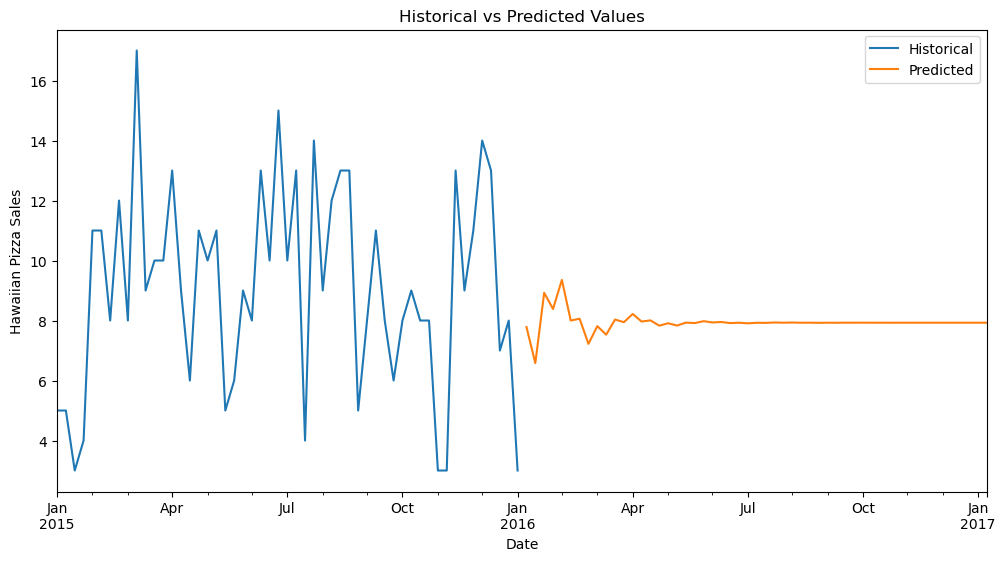

MAPE: 0.39


,historical,predicted
2015-01-04,5.0,NaN
2015-01-11,5.0,NaN
2015-01-18,3.0,NaN
2015-01-25,4.0,NaN
2015-02-01,11.0,NaN
...,...,...
2016-12-11,NaN,7.926944
2016-12-18,NaN,7.926743
2016-12-25,NaN,7.926828
2017-01-01,NaN,7.926741


In [25]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Ensure the data is indexed by date
pizza_dfs['hawaiian_m'].index = pd.to_datetime(pizza_dfs['hawaiian_m'].index)

# Fit the ARIMA model
model = ARIMA(pizza_dfs['hawaiian_m'], order=(7, 1, 0)).fit()

# Make predictions for the next n periods (here we use the length of the historical data)
n_periods = len(pizza_dfs['hawaiian_m'])
forecast = model.forecast(steps=n_periods)


# Combine historical and predicted data for comparison
historical_data = pizza_dfs['hawaiian_m']
comparison_df = pd.DataFrame({
    'historical': historical_data,
    'predicted': forecast
})

# Calculate MAPE
mape = mean_absolute_percentage_error(comparison_df['historical'][:53], comparison_df['predicted'][53:])

# Plot the historical and predicted values
comparison_df.plot(figsize=(12, 6))
plt.title('Historical vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Hawaiian Pizza Sales')
plt.legend(['Historical', 'Predicted'])
plt.show()

print(f"MAPE: {mape:.2f}")
comparison_df

-----------------------------------------------------

In [28]:
import warnings
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Suppress warnings
warnings.filterwarnings("ignore")


best_result = []


for pdq in pdq_comb:
    try:
        # Fit the SARIMAX model
        model = SARIMAX(pizza_dfs['hawaiian_m'], order=pdq, seasonal_order=(0, 0, 0, 0)).fit()
        
        # Make predictions
        predicted_values = model.forecast(steps=len(pizza_dfs['hawaiian_m']))
        
        # Calculate MAPE
        mape = mean_absolute_percentage_error(pizza_dfs['hawaiian_m'], predicted_values)
        
        # Store the MAPE and corresponding seasonal order
        best_result.append({
            'seasonal_order': pdq,
            'MAPE': mape,
            'pizza': 'hawaiian_m'
        })
        
        
    except:
        continue

filtered_results = [result for result in best_result if result['MAPE'] < 0.10 and result['pizza'] == pizza_id]
print(filtered_results)

    
# Find the best seasonal order combination with the lowest MAPE for each pizza_id
for pizza_id in pizza_ids:
    results_for_pizza = [result for result in best_result if result['pizza'] == pizza_id]
    if results_for_pizza:
        best_seasonal = min(results_for_pizza, key=lambda x: x['MAPE'])
        print(f"Best seasonal order for pizza {pizza_id}: {best_seasonal['seasonal_order']}")
        print(f"Best MAPE for pizza {pizza_id}: {best_seasonal['MAPE']}")


[]
Best seasonal order for pizza hawaiian_m: (7, 1, 0)
Best MAPE for pizza hawaiian_m: 0.39279488541305047


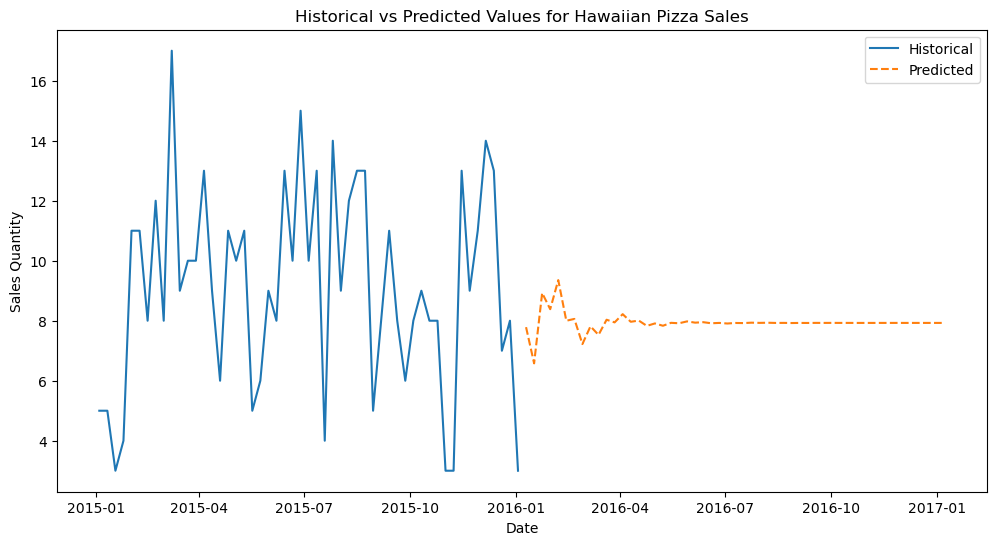

In [32]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Suppress warnings
warnings.filterwarnings("ignore")

pizza_id = 'hawaiian_m'  # Replace with your specific pizza_id

# Fit the SARIMAX model
model = SARIMAX(pizza_dfs[pizza_id], order=(7, 1, 0), seasonal_order=(0, 0, 0, 0)).fit()

# Make predictions for the same period as the historical data
predicted_values = model.forecast(steps=len(pizza_dfs[pizza_id]))

# Combine historical and predicted data for plotting
comparison_df = pd.DataFrame({
    'historical': pizza_dfs[pizza_id],
    'predicted': predicted_values
})

# Plot the historical and predicted values
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['historical'], label='Historical')
plt.plot(comparison_df['predicted'], label='Predicted', linestyle='--')
plt.title('Historical vs Predicted Values for Hawaiian Pizza Sales')
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.legend(['Historical', 'Predicted'])
plt.show()


------------------------------------------------------------------

In [114]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [115]:
df.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,year,month,day,day_of_week,week_number,is_weekend,season
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,2015,1,1,3,1,False,Winter
1,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,2015,1,1,3,1,False,Winter
2,3,2,five_cheese_l,1,2015-01-01,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza,2015,1,1,3,1,False,Winter
3,4,2,ital_supr_l,1,2015-01-01,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza,2015,1,1,3,1,False,Winter
4,5,2,mexicana_m,1,2015-01-01,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,2015,1,1,3,1,False,Winter


In [116]:
xgb_df = df[['pizza_name_id','order_date','month','day','day_of_week','week_number','is_weekend','quantity']]

In [117]:
xgb_df

,pizza_name_id,order_date,month,day,day_of_week,week_number,is_weekend,quantity
0,hawaiian_m,2015-01-01,1,1,3,1,False,1
1,classic_dlx_m,2015-01-01,1,1,3,1,False,1
2,five_cheese_l,2015-01-01,1,1,3,1,False,1
3,ital_supr_l,2015-01-01,1,1,3,1,False,1
4,mexicana_m,2015-01-01,1,1,3,1,False,1
...,...,...,...,...,...,...,...,...
48615,ckn_alfredo_m,2015-12-31,12,31,3,53,False,1
48616,four_cheese_l,2015-12-31,12,31,3,53,False,1
48617,napolitana_s,2015-12-31,12,31,3,53,False,1
48618,mexicana_l,2015-12-31,12,31,3,53,False,1


In [118]:
xgb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   pizza_name_id  48620 non-null  object        
 1   order_date     48620 non-null  datetime64[ns]
 2   month          48620 non-null  int32         
 3   day            48620 non-null  int32         
 4   day_of_week    48620 non-null  int32         
 5   week_number    48620 non-null  UInt32        
 6   is_weekend     48620 non-null  bool          
 7   quantity       48620 non-null  int64         
dtypes: UInt32(1), bool(1), datetime64[ns](1), int32(3), int64(1), object(1)
memory usage: 1.9+ MB


In [119]:
xgb_df['is_weekend'] = xgb_df['is_weekend'].astype(int)

In [120]:
xgb_df.tail()

,pizza_name_id,order_date,month,day,day_of_week,week_number,is_weekend,quantity
48615,ckn_alfredo_m,2015-12-31,12,31,3,53,0,1
48616,four_cheese_l,2015-12-31,12,31,3,53,0,1
48617,napolitana_s,2015-12-31,12,31,3,53,0,1
48618,mexicana_l,2015-12-31,12,31,3,53,0,1
48619,bbq_ckn_s,2015-12-31,12,31,3,53,0,1


In [125]:
# Aggregate the data by 'order_date' and 'pizza_name_id'
aggregated_df = xgb_df.groupby(['order_date', 'pizza_name_id']).agg({
    'quantity': 'sum'
}).reset_index()

# Create separate DataFrames for each pizza ID and resample weekly
pizza_ids = aggregated_df['pizza_name_id'].unique()
pizza_dfs = {}

for pizza_id in pizza_ids:
    temp_df = aggregated_df[aggregated_df['pizza_name_id'] == pizza_id]
    temp_df.set_index('order_date', inplace=True)
    temp_df = temp_df.drop('pizza_name_id', axis=1)

    # Resample weekly and sum quantities
    weekly_resampled = temp_df['quantity'].resample('W').sum().reset_index()

    # Add week_number, month, and week_of_month features
    weekly_resampled['week_number'] = weekly_resampled['order_date'].dt.isocalendar().week
    weekly_resampled['month'] = weekly_resampled['order_date'].dt.month
    weekly_resampled['week_of_month'] = (weekly_resampled['order_date'].dt.day - 1) // 7 + 1
    weekly_resampled.drop('order_date',axis=1, inplace=True)
    pizza_dfs[pizza_id] = weekly_resampled
    print(f"DataFrame for {pizza_id}:\n{pizza_dfs[pizza_id]}\n")

# Example output for verification
for pizza_name, df in pizza_dfs.items():
    print(f"DataFrame for {pizza_name}:\n{df}\n")


DataFrame for bbq_ckn_l:
    quantity  week_number  month  week_of_month
0         18            1      1              1
1         13            2      1              2
2         25            3      1              3
3         15            4      1              4
4         29            5      2              1
5         18            6      2              2
6         27            7      2              3
7         16            8      2              4
8         18            9      3              1
9         25           10      3              2
10        18           11      3              3
11        20           12      3              4
12        21           13      3              5
13        19           14      4              1
14        23           15      4              2
15        22           16      4              3
16        19           17      4              4
17        19           18      5              1
18        18           19      5              2
19        21   

In [126]:
pizza_dfs['hawaiian_m']

,quantity,week_number,month,week_of_month
0,5,1,1,1
1,5,2,1,2
2,3,3,1,3
3,4,4,1,4
4,11,5,2,1
5,11,6,2,2
6,8,7,2,3
7,12,8,2,4
8,8,9,3,1
9,18,10,3,2


In [128]:
X = pizza_dfs['hawaiian_m'].drop(['quantity'], axis=1) 
y = pizza_dfs['hawaiian_m']['quantity']

In [95]:
from pandas.tseries.offsets import DateOffset

# Generate a date range for 2016 with weekly frequency
date_range = pd.date_range(start='2016-01-01', end='2016-12-31')


# Prepare a list to store the data
data = []

# Loop through each pizza name and date to create the rows

for date in date_range:
    # Create the feature values
    month = date.month
    day = date.day
    day_of_week = date.dayofweek
    week_number = date.isocalendar().week
    is_weekend = day_of_week >= 5

    # Append the row to the data list
    data.append([month, day, day_of_week, week_number, is_weekend])

# Create the DataFrame
df_test_2016 = pd.DataFrame(data, columns=[
    'month', 'day', 'day_of_week', 'week_number', 'is_weekend'
])

# Convert boolean to integer
df_test_2016['is_weekend'] = df_test_2016['is_weekend'].astype(int)

df_test_2016.head()



,month,day,day_of_week,week_number,is_weekend
0,1,1,4,53,0
1,1,2,5,53,1
2,1,3,6,53,1
3,1,4,0,1,0
4,1,5,1,1,0


In [96]:
X_train, X_test = X,y

In [97]:
# Create a DMatrix for XGBoost with the entire dataset
dtrain = xgb.DMatrix(X, label=y)

# Set parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

# Train the model on the entire dataset
model = xgb.train(params, dtrain, num_boost_round=100)

print("Model trained on the entire dataset.")


Model trained on the entire dataset.


In [98]:
# Create a DMatrix for XGBoost with the test data
dtest = xgb.DMatrix(df_test_2016)

# Predict on the test set
predictions = model.predict(dtest)


In [129]:
# Create a DMatrix for XGBoost with the entire dataset
dtrain = xgb.DMatrix(X, label=y)

# Set parameters for the XGBoost model
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'rmse'
}

# Train the model on the entire dataset
model = xgb.train(params, dtrain, num_boost_round=100)

# Predict on the training set
train_predictions = model.predict(dtrain)

# Calculate MAPE on the training data
mape_train = mean_absolute_percentage_error(y, train_predictions)
print(f'MAPE on Training Data: {mape_train:.2f}%')


MAPE on Training Data: 0.02%


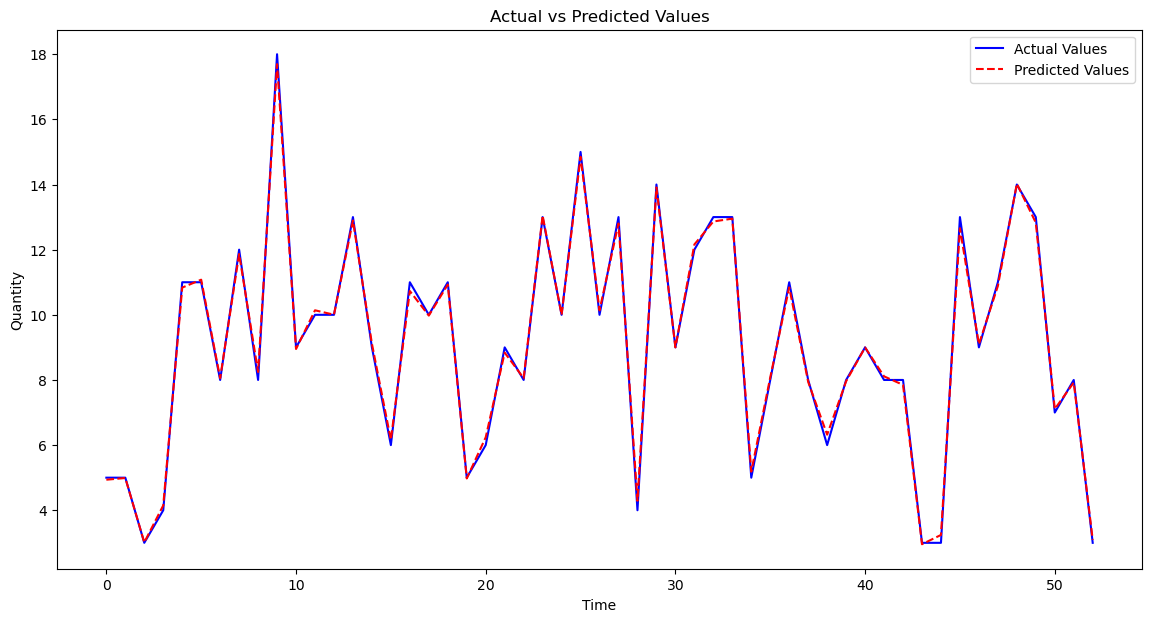

In [130]:
# Plotting actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y.values, label='Actual Values', color='blue')
plt.plot(train_predictions, label='Predicted Values', color='red', linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [136]:
import pandas as pd

# Generate a date range for 2016
date_range = pd.date_range(start='2016-01-01', end='2016-12-31')

# Create a DataFrame with the date range
df_2016 = pd.DataFrame(date_range, columns=['order_date'])

# Extract features from the date
df_2016['week_number'] = df_2016['order_date'].dt.isocalendar().week
df_2016['month'] = df_2016['order_date'].dt.month
df_2016['week_of_month'] = (df_2016['order_date'].dt.day - 1) // 7 + 1

# Resample the DataFrame weekly
weekly_df = df_2016.resample('W', on='order_date').agg({
    'week_number': 'first',
    'month': 'first',
    'week_of_month': 'first'
}).reset_index()
weekly_df.drop('order_date', axis=1, inplace=True)
# Display the resulting DataFrame
weekly_df


,week_number,month,week_of_month
0,53,1,1
1,1,1,1
2,2,1,2
3,3,1,3
4,4,1,4
5,5,2,1
6,6,2,2
7,7,2,3
8,8,2,4
9,9,2,5


In [138]:
import xgboost as xgb

# Create a DMatrix for XGBoost with the test data
dtest = xgb.DMatrix(weekly_df)

# Predict on the test set
predictions_2016 = model.predict(dtest)

# Add predictions to df_2016 for comparison
weekly_df['predictions'] = predictions_2016


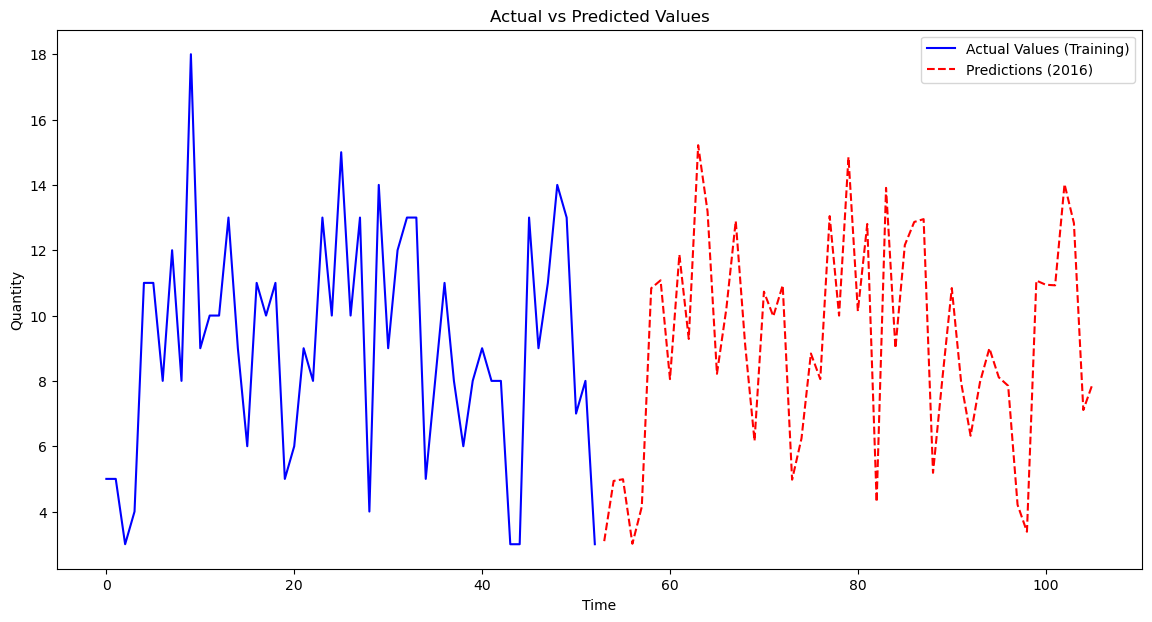

In [139]:
import matplotlib.pyplot as plt

# Assuming y represents the actual values from the training dataset
# Plot actual values from training data
plt.figure(figsize=(14, 7))
plt.plot(range(len(y)), y, label='Actual Values (Training)', color='blue')

# Plot predictions for 2016
plt.plot(range(len(y), len(y) + len(predictions_2016)), predictions_2016, label='Predictions (2016)', color='red', linestyle='dashed')

plt.xlabel('Time')
plt.ylabel('Quantity')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


In [140]:
mape_2016 = mean_absolute_percentage_error(pizza_dfs['hawaiian_m']['quantity'], predictions_2016) 
print(f'MAPE on 2016 Data: {mape_2016:.2f}%')

MAPE on 2016 Data: 0.44%


In [150]:
weekly_df['predictions'] = weekly_df['predictions'].round()

In [154]:
# Merge df2 into df1 on 'week_number' column
merged_df = pd.merge(pizza_dfs['hawaiian_m'][['week_number','quantity']], weekly_df[['week_number','predictions']], on='week_number', how='right')

# Calculate MAPE manually
merged_df['percentage_error'] = (abs(merged_df['quantity'] - merged_df['predictions']) / merged_df['quantity']) 
mape_manual = merged_df['percentage_error'].mean()
print(f'MAPE (manual calculation): {mape_manual:.2f}%')



MAPE (manual calculation): 0.03%
